# Финальный проект по направлению Data Engineer. Junior 

Цель проекта - пазработка пайплайна и структур хранения данных для анализа данных о поездках такси Нью-Йорка с 01.01.2009 по настоящее время. Полное описание задания на проект - в файле <a href="Описание финальной работы курса «Data Engineer. Junior».pdf">Описание финальной работы курса «Data Engineer. Junior».pdf</a>

## Используемый стек

## Разработка схемы данных

### Staging-слой

В staging-слое используем две таблицы:
- временную таблицу staging_data для загрузки данных из скачанных файлов;
- таблицу bronze_files для отслеживания, какие файлы были скачаны и какие из них обработаны для серебряного и золотого слоев.

1. Данные из исходных файлов загружаем в staging-таблицу по одному файлу за проход.
2. Так как состав и названия полей исходных файлов данных менялись, для staging-таблицы не задаем предопределенную структуру, а используем CREATE TABLE ... AS SELECT DISTINCT FROM s3(...), добавляя поля load_timestamp и record_source. В этом случае структура таблицы будет выбрана автоматически. Перед каждой следующей загрузкой вместо очистки таблицы через TRUNCATE удаляем таблицу целиком - так как в следующем файле могут быть уже другие поля.
3. Так как время скачивания файла значительно превышает время его последующей обработки, не используем Spark - импортируем данные из скачанного файла непосредственно в таблицу ClickHouse.

Схема БД staging-слоя:

![Staging layer schema.png](<attachment:Staging layer schema.png>)
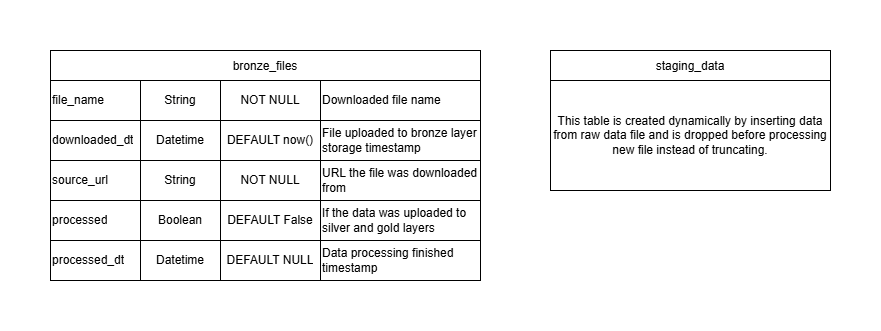

### Серебряный слой

Для серебряного слоя выделяем следующие бизнес-сущности:
- поездка;
- зона посадки/высадки;
- способ оплаты,

а так же:
- тариф;
- поставщик информации,

так как их некорректно выделять в справочники и неудобно хранить в атрибутах.

Проектируем серебряный слой в соответствии с методологией Data Vault с использованием хабов, линков и сателлитов.
- hub_trip - уникальные идентификаторы поездок. Уникальность поездки определяем по сочетанию времени и зоны посадки, времени и зоны высадки и стоимости поездки. В качестве идентификатора используем хэш перечисленных полей. В Clickhouse используем движок ReplacingMergeTree с объединением по идентификатору на случай повторной загрузки данных из одного источника.
- хабы hub_vendor, hub_rate, hub_payment_type, hub_taxi_zone и их сателлиты представляют собой небольшие справочники. В hub_taxi_zone и sat_taxi_zone_details количество записей не превышает 300, в остальных таблицах - менее 10. Со временем данные не меняются либо меняются очень редко. Для экономии ресурсов используем движок TinyLog. Проверку на уникальность записей производим при загрузке данных в эти таблицы.
- sat_trip_details - таблица с основными данными о поездке. Данные о совершившейся поездке не меняются со временем, поддержка версионности не нужна. Используем движок ReplacingMergeTree для удаления дубликатов в случае повторной загрузки из одного источника. Партиционируем по времени начала поездки ежемесячно.
- для всех полей record_source используем тип LowCardinality(String). Это особенно критично для таблиц hub_trip, sat_trip_details и всех линков так как примерно у каждых 10 000 000 записей в этом поле будет одно и то же длинное строковое значение.
- так как во времени данные о поездке не меняются, по факту все линки связывают поездки с остальными хабами связью "один-к-одному", однако линки оставляем в модели для чистоты соответствия концепции Data Vault.


![Silver layer schema.png](<attachment:Silver layer schema.png>)
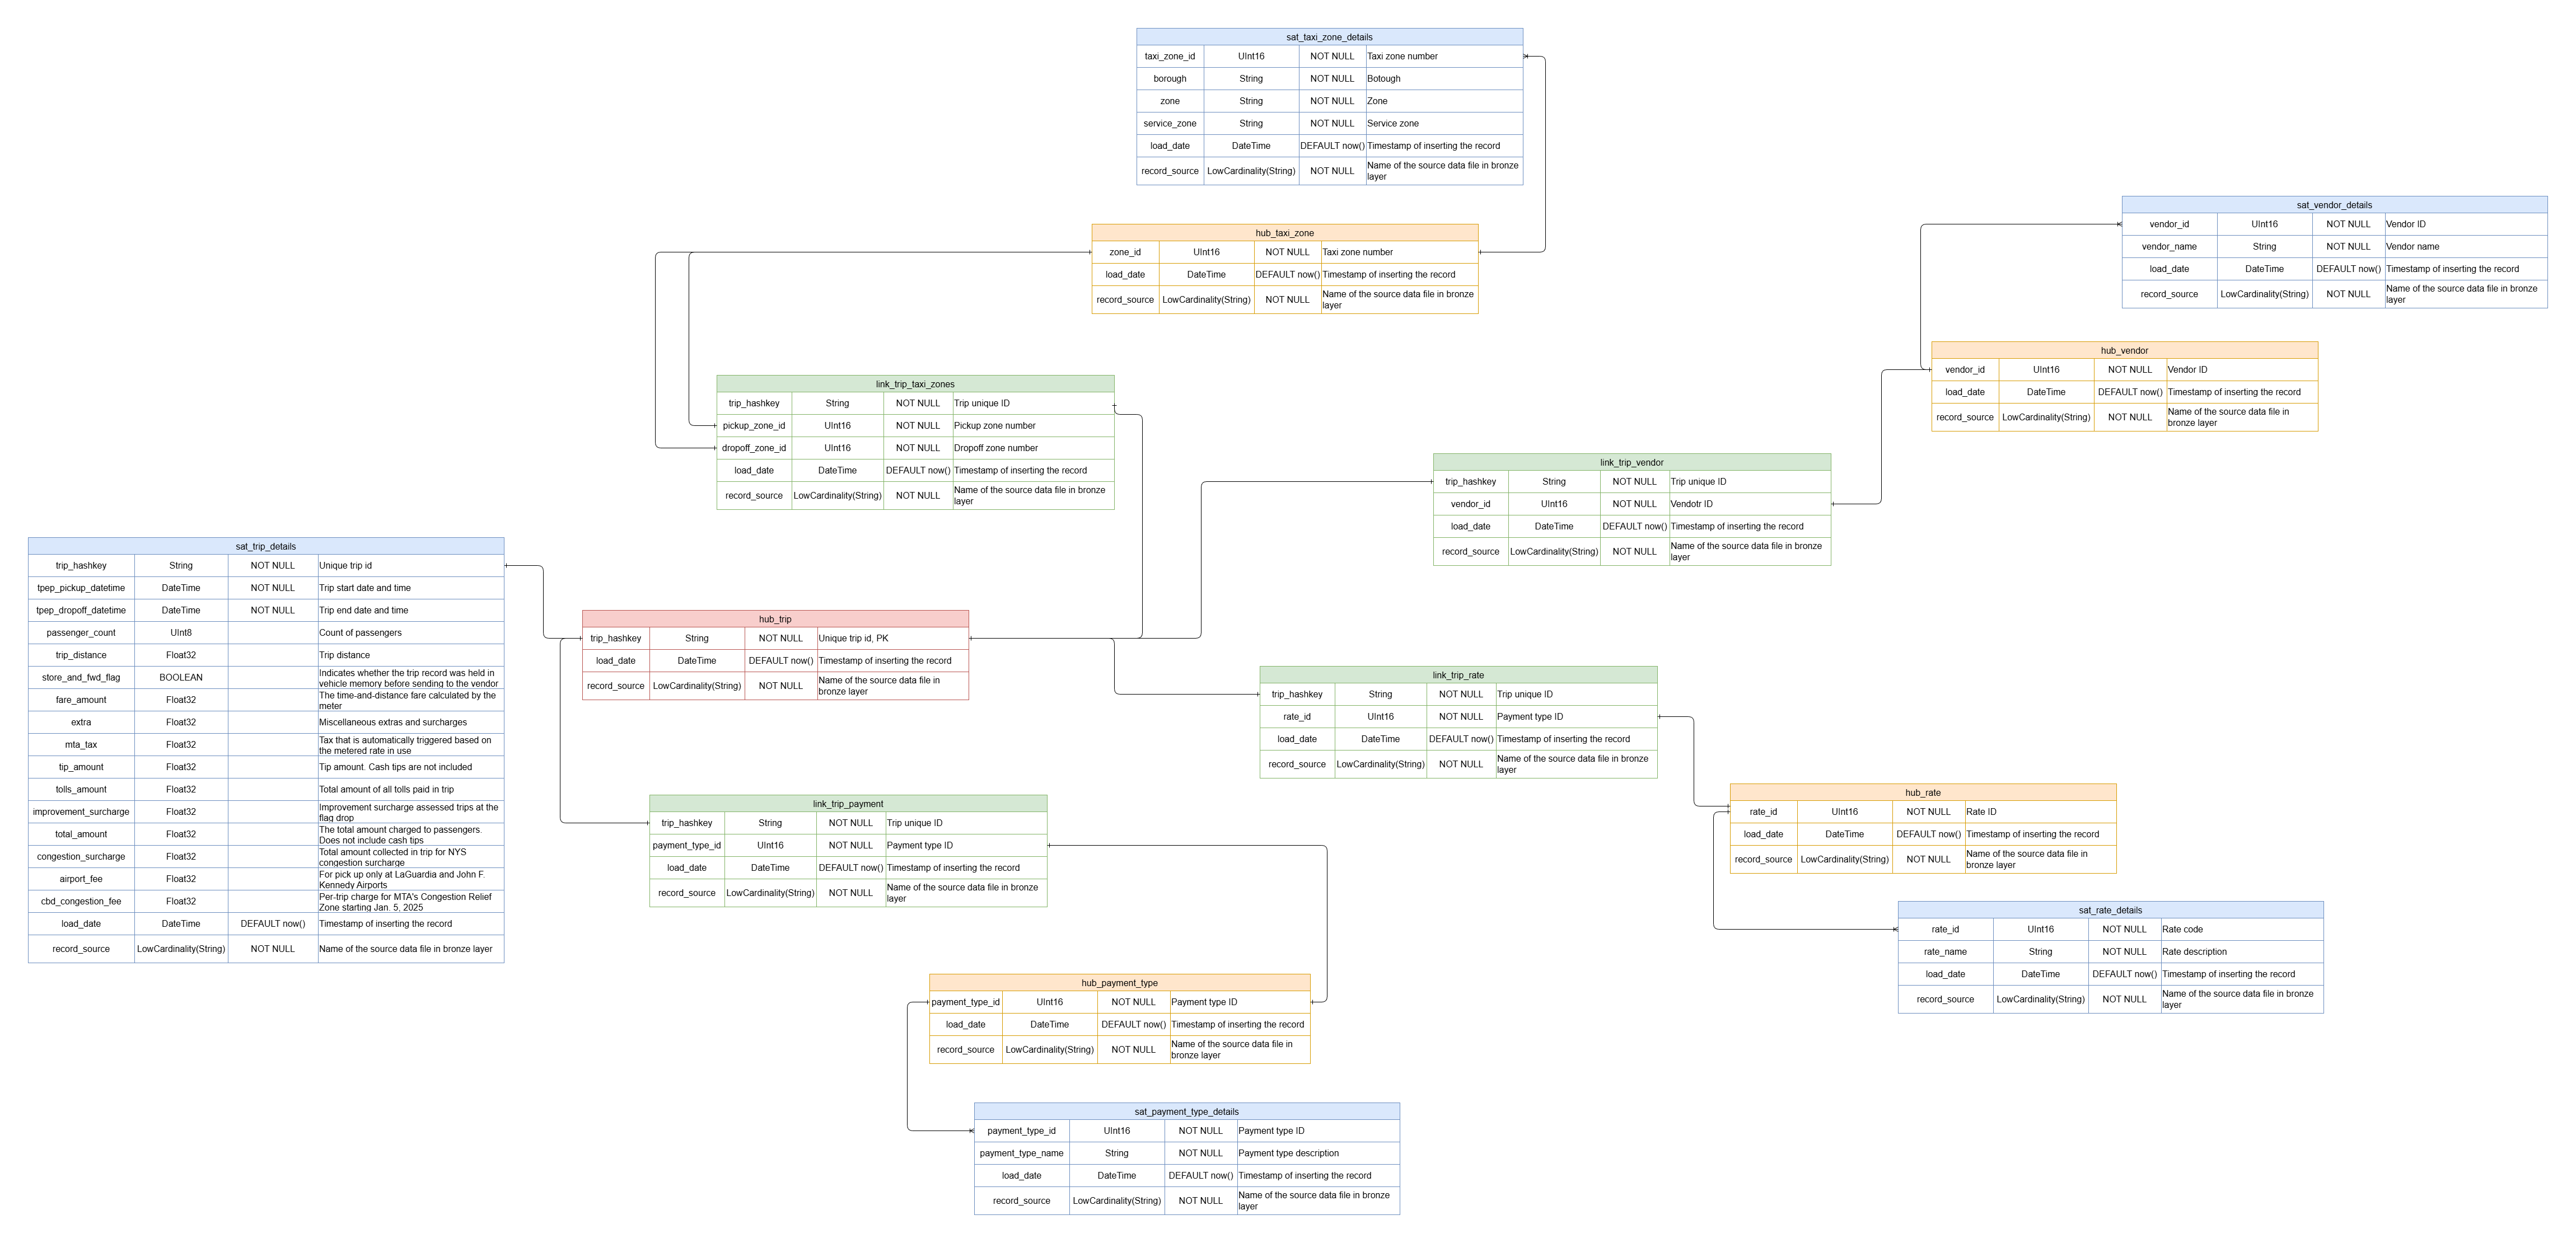

### Золотой слой

Золотой слой строим по схеме "звезда".
Факты:
- поездка

Измерения:
- зона посадки
- зона высадки
- время суток
- день недели?
- тип оплаты
- тип поездки

## Инициализация инфраструктуры

Инициализация проводится путем однократного запуска в Airflow DAG nyc_taxi_initalize. В рамках инициализации выполняются следующие действия:
- проверяется доступность необходимых хранилищ и бакетов. В случае отстуствия бакетов - пытаемся их создать.
- проверяется доступность сервера Clickhouse.
- проверяется существование необходимых БД в Clickhouse. В случае отсутствия - пытаемся их создать.
- создаются необходимые таблицы в каждой из БД. Так как таблицы создаются с использованием IF NOT EXISTS, предварительная проверка существования не проводится.
- скачивается shape-файл для определения зоны начала и окончания поездки.
- скачивается файл со список зон. Данные из файла загружаются в хаб серебряного слоя hub_taxi_zone.


## Формирование бронзового слоя. Скачивание данных с источника

Исходные файлы данных скачиваются с сайта-источника и загружаются в хранилище бронзового слоя в неизменном виде. Скачивание производится регулярно с помощью Airflow DAG get_bronze_data. Так как новые файлы появляются не чаще, чем раз в месяц и с двухмесячным опозданием, выбираем еженедельный запуск DAG. Информация о каждом скачанном файле сохраняется в таблице bronze_files базы данных staging-слоя.

## Обработка данных для staging, серебряного и золотого слоев

## Ответы на аналитические вопросы

## Предложения по оптимизации

## Заключение